In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
# Sunspots.csv
!git clone https://github.com/shivigup/sunspots

Cloning into 'sunspots'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [4]:
import pandas as pd

df = pd.read_csv("sunspots/data/Sunspots.csv")
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df['Date'] = pd.to_datetime(df['Date'])

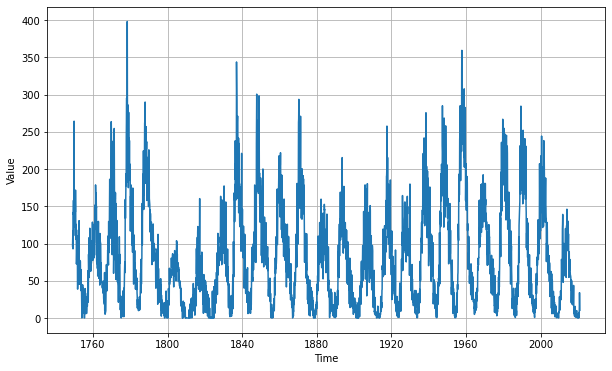

In [5]:
time = df['Date']
series = df['Monthly Mean Total Sunspot Number']

plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 12
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
def my_huber_loss(y_true, y_pred):   
  
    threshold = 200     
    error = y_true - y_pred     
    is_lesser = tf.abs(y_true) <= threshold     
    return tf.where(is_lesser, tf.abs(error), 2*tf.abs(error))

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=my_huber_loss,
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 4s 56ms/step - loss: 88.5134 - mae: 75.7187
Epoch 2/100
10/10 [==============================] - 1s 52ms/step - loss: 86.9669 - mae: 74.3074
Epoch 3/100
10/10 [==============================] - 1s 58ms/step - loss: 84.5402 - mae: 72.0679
Epoch 4/100
10/10 [==============================] - 1s 56ms/step - loss: 81.5957 - mae: 69.3402
Epoch 5/100
10/10 [==============================] - 1s 57ms/step - loss: 78.2941 - mae: 66.2761
Epoch 6/100
10/10 [==============================] - 1s 58ms/step - loss: 74.7732 - mae: 63.0099
Epoch 7/100
10/10 [==============================] - 1s 59ms/step - loss: 71.1488 - mae: 59.6629
Epoch 8/100
10/10 [==============================] - 1s 55ms/step - loss: 67.5850 - mae: 56.3903
Epoch 9/100
10/10 [==============================] - 1s 56ms/step - loss: 64.1886 - mae: 53.2977
Epoch 10/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

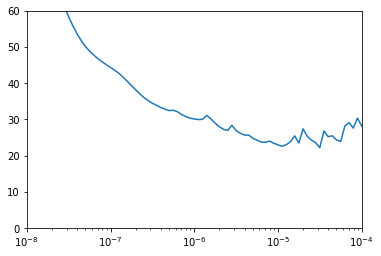

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
#model.compile(loss=tf.keras.losses.Huber(),
#              optimizer=optimizer,
#              metrics=["mae"])

model.compile(loss=my_huber_loss,
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=500)

Epoch 1/500
25/25 [==============================] - 4s 36ms/step - loss: 56.4487 - mae: 47.4177
Epoch 2/500
25/25 [==============================] - 1s 35ms/step - loss: 38.3141 - mae: 31.1499
Epoch 3/500
25/25 [==============================] - 1s 35ms/step - loss: 34.6466 - mae: 28.5081
Epoch 4/500
25/25 [==============================] - 1s 35ms/step - loss: 32.9946 - mae: 27.4298
Epoch 5/500
25/25 [==============================] - 1s 37ms/step - loss: 31.8783 - mae: 26.6254
Epoch 6/500
25/25 [==============================] - 1s 36ms/step - loss: 30.9878 - mae: 26.0971
Epoch 7/500
25/25 [==============================] - 1s 36ms/step - loss: 30.1814 - mae: 25.4772
Epoch 8/500
25/25 [==============================] - 1s 35ms/step - loss: 29.4018 - mae: 24.9344
Epoch 9/500
25/25 [==============================] - 1s 35ms/step - loss: 28.6053 - mae: 24.3562
Epoch 10/500
25/25 [==============================] - 1s 36ms/step - loss: 27.8833 - mae: 23.7959
Epoch 11/500
25/25 [=========

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


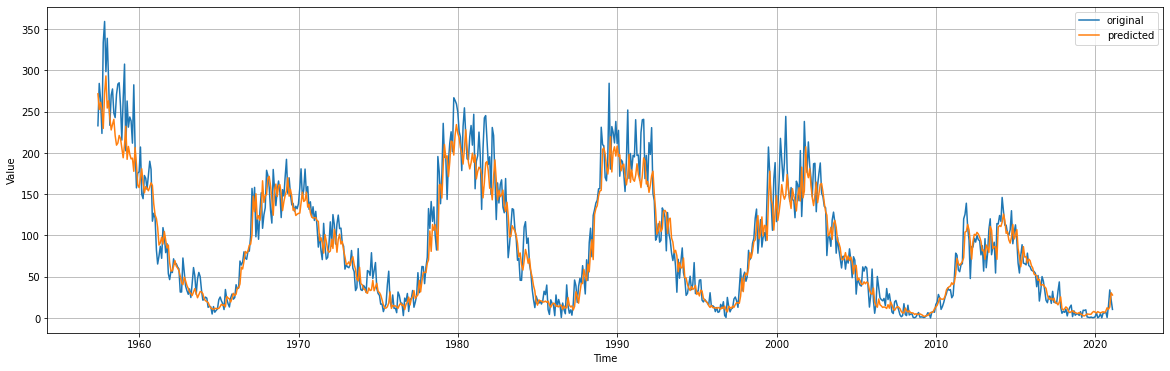

In [15]:
plt.figure(figsize=(20, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.legend(["original", "predicted"])
plt.savefig("conv.png")
plt.show()

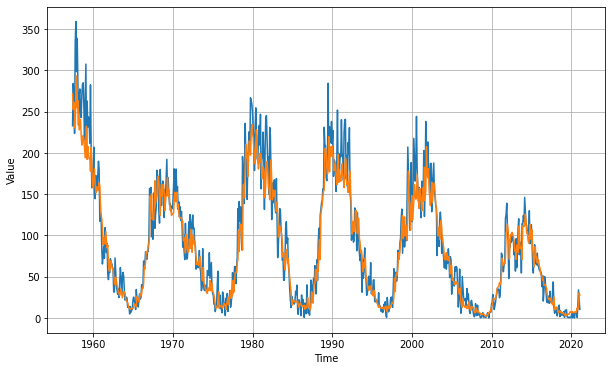

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [17]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
mse = tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy()
print(mae/len(x_valid))
print(mse/len(x_valid))

0.021991667404673457
0.7920934340533088


In [18]:
print(mae)
print(mse)

16.823626
605.9515


In [19]:
m = tf.keras.metrics.MeanRelativeError(normalizer=x_valid)
m.update_state(x_valid, rnn_forecast)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=765.0>

In [20]:
m.result().numpy()

0.5888955

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)